In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [3]:
df = pd.read_hdf('Danionella.h5')

In [4]:
df.head(10)

x         y     theta  tail_angle_01  tail_angle_02  \
frame_id                                                               
305901    354.6027  762.4877  1.688693      -0.057569      -0.098585   
305902    354.7846  762.4101  1.679170      -0.049721      -0.110686   
305903    354.7972  762.2639  1.680839      -0.063216      -0.105089   
305904    354.9238  762.0828  1.677423      -0.060133      -0.113719   
305905    354.8554  762.4290  1.676634      -0.036935      -0.148548   
305906    354.9251  762.2833  1.676751      -0.025943      -0.151010   
305907    354.9701  762.2706  1.679253      -0.029676      -0.154981   
305908    355.0045  762.0753  1.681015      -0.049407      -0.124992   
305909    354.9362  762.7366  1.679855      -0.003576      -0.172042   
305910    354.9089  762.6892  1.683179      -0.021265      -0.109144   

          tail_angle_03  tail_angle_04  tail_angle_05  tail_angle_06  \
frame_id                                                               
305901         0.079641       0.049129      -0.082754      -0.128328   
305902         0.082935       0.060231      -0.066932      -0.100862   
305903         0.083205       0.053699      -0.052808      -0.083353   
305904         0.073875       0.065227      -0.009110      -0.101244   
305905         0.095650       0.001300       0.095087      -0.151557   
305906         0.034835       0.084802       0.017422      -0.076704   
305907         0.040370       0.071754       0.004252      -0.026808   
305908         0.026483       0.080777      -0.039683       0.034957   
305909        -0.014626       0.082224       0.014183       0.051321   
305910        -0.092486       0.054679       0.077161       0.003881   

          tail_angle_07  ...  tail_value_01  tail_value_02  tail_value_03  \
frame_id                 ...                                                
305901        -0.083319  ...       110.2709       107.3225       60.82891   
305902        -0.116938  ...       108.7593       118.9064       71.30074   
305903        -0.116282  ...       112.0417       119.4430       82.47068   
305904        -0.110419  ...       113.9246       124.5385       92.53473   
305905        -0.096062  ...       112.6283       113.8588       97.03622   
305906        -0.084571  ...       116.6183       113.7184       91.00258   
305907        -0.088701  ...       119.7308       112.0695       88.51680   
305908        -0.095538  ...       117.7122       113.0838       84.81815   
305909        -0.101861  ...       127.7499       123.9602       86.90324   
305910        -0.014184  ...       130.2539       107.3957       91.64360   

          tail_value_04  tail_value_05  tail_value_06  tail_value_07  \
frame_id                                                               
305901         90.88052       76.23203       51.16987       44.68130   
305902         84.24125       77.45908       48.44184       46.75766   
305903         82.50231       69.73067       52.13729       47.75901   
305904         83.81439       74.69270       54.38569       47.64020   
305905         96.01034       59.95189       62.38118       45.84756   
305906         97.86189       73.53310       51.08514       49.02306   
305907         88.31061       75.30571       53.76753       52.34233   
305908         80.49852       82.55347       57.28442       52.53932   
305909         71.24934       75.41571       52.09628       47.68031   
305910         72.87362       64.86969       65.13358       45.11681   

          tail_value_08  tail_value_09  tail_value_10  
frame_id                                               
305901         43.60098        0.00000            0.0  
305902         48.87668        3.97171            0.0  
305903         42.42837        0.00000            0.0  
305904         43.64951        0.00000            0.0  
305905         42.23901        0.00000            0.0  
305906         43.50781        0.00000            0.0  
305907         41.39820        0.00000           

# Segmentation Class:

# Attributes:
* Tail Angle
* Nan Interp Tail Angle
* Smooth Tail Angle
* BoutThresh
* Half Beat Positive, Negative
* Bout Onset, Offset

# Functions:
* Find threshold of activity
* Oversample Bouts
* Find Half Beat
* Clean Half Beat
* Plot Diagnostic: threshold,Half Beat, Smoothing, Bout Segmentation

In [5]:
from utils.utils_bouts import diff_but_better,compute_smooth_tail_angle,compute_tail_speed,mexican_hat_tail_speed,estimate_speed_threshold,find_onset_offset_numpy
from utils.utils_beat import refine_segmentation_bouts,find_zeros_crossing,is_there_oscillation,clean_peak_forcing_distance,clean_peak_forcing_alternation,interleave,is_break_in_amplitude,is_break_in_interbeatinterval,is_there_signal

In [6]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy import stats
def estimate_speed_threshold_using_GMM(speed,margin_std,axis=None):
    
    log_speed = np.log(speed[speed>0])
    #bin_log_min = -5
    #bin_log_max = 5
    #count,edge = np.histogram(log_speed,np.arange(bin_log_min,bin_log_max,0.1))
    #bins = (edge[:-1]+edge[1:])/2

    X = log_speed[:,np.newaxis]
    gm = GaussianMixture(n_components=2, random_state=0).fit(X)

    weights = gm.weights_
    means = gm.means_
    covars = gm.covariances_

    id = np.argmin(means)
    sigma  = np.sqrt(covars[id]) # Standard Deviation
    BoutThresh = np.exp(means[id] + margin_std*sigma)[0]
    f_axis = log_speed.copy().ravel()
    f_axis.sort()
    if axis is not None:
        axis.hist(log_speed, bins=1000, histtype='bar', density=True, ec='red', alpha=0.1)
        #axis.plot(bins,count)
        axis.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='blue')
        axis.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='blue')
        axis.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel()+weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(),
        c='green')

    return BoutThresh[0],axis


In [7]:

def tail_angle_preprocessing(tail_angle,NumSegments=7,BCFilt=10,MinFiltSize=400,MaxFiltSize=20):

    # Smooth Tail angle and compute measure of intensity
    cumul_tail_angle,smooth_cumul_tail_angle,notrack = compute_smooth_tail_angle(tail_angle)
    smooth_tail_speed,speed_tail_angle,super_cumul = compute_tail_speed(smooth_cumul_tail_angle,notrack,NumSegments,BCFilt)
    
    # MinFilt remove unstable baseline & MaxFilt merge bouts
    low_pass_tail_speed,max_filt,min_filt = mexican_hat_tail_speed(smooth_tail_speed,MinFiltSize,MaxFiltSize)
    
    # Compute Speed:
    tail_angle_speed = np.zeros_like(smooth_cumul_tail_angle)

    for s in range(tail_angle_speed.shape[1]):
        tail_angle_speed[:,s] = diff_but_better(smooth_cumul_tail_angle[:,s],dt=1/700, filter_length=71)
    
    return smooth_cumul_tail_angle,low_pass_tail_speed,tail_angle_speed,notrack

In [8]:
def find_half_beat(bout_slice,Half_BCFilt = 150, stdThres = 5,MinSizeBlob = 500):
    BCFilt = Half_BCFilt*2+1
    X = bout_slice
    oversample_slice = cv2.resize(X, dsize=(X.shape[1],X.shape[0]*10), interpolation=cv2.INTER_CUBIC)
        
    filtered_=np.zeros_like(oversample_slice)
    binary_thresh_up=np.zeros_like(oversample_slice)
    binary_thresh_down=np.zeros_like(oversample_slice)
    for i in range(oversample_slice.shape[1]):
            filtered_[:,i]= signal.convolve(oversample_slice[:,i],1/BCFilt*signal.boxcar(M=BCFilt,sym=True),mode='same')
            sigma = np.std(filtered_[:,i])
            binary_thresh_up[:,i] = filtered_[:,i]+sigma/stdThres
            binary_thresh_down[:,i] = filtered_[:,i]-sigma/stdThres

    binary_image = np.zeros_like(oversample_slice)
    for i in range(oversample_slice.shape[1]):
        binary_image[:,i] = (oversample_slice[:,i]>binary_thresh_up[:,i]) + -1*(oversample_slice[:,i]<binary_thresh_down[:,i])
    
    all_labels_pos = measure.label((binary_image)==1)
    if len(np.where(all_labels_pos)[0])>0:
        props_pos = regionprops_table(all_labels_pos, properties=('area','centroid'))#,
        half_beat_pos = []
        for i,lab_ in enumerate(np.unique(all_labels_pos)[1:]):
            if props_pos['area'][i]> MinSizeBlob:
                id = np.where(all_labels_pos[:,-1]==lab_)[0]
                #np.argmax(res[id,8])
                if len(id)>0:
                    half_beat_pos.append(id[np.argmax(oversample_slice[id,-1])])
    else:
        half_beat_pos = []

    all_labels_neg = measure.label((binary_image)==-1)
    if len(np.where(all_labels_neg)[0])>0:
        props_neg = regionprops_table(all_labels_neg, properties=('area','centroid'))
        half_beat_neg = []
        for i,lab_ in enumerate(np.unique(all_labels_neg)[1:]):
            if props_neg['area'][i]> MinSizeBlob:
                id = np.where(all_labels_neg[:,-1]==lab_)[0]
                #np.argmax(res[id,8])
                if len(id)>0:
                    half_beat_neg.append(id[np.argmin(oversample_slice[id,-1])])
    else:
        half_beat_neg = []

    half_beat_pos = np.floor(np.array(half_beat_pos)/10).astype('int')
    half_beat_neg = np.floor(np.array(half_beat_neg)/10).astype('int')

    return half_beat_pos,half_beat_neg,binary_image

In [9]:
import cv2
import scipy.signal as signal

from skimage import measure
from skimage import filters
from skimage.measure import label, regionprops,regionprops_table


In [10]:
class Segmentation:
    
    def __init__(self,
                 tail_angle, # Input shouldn't be cumulated
                 fps = 700,
                 Reference_tail_segment = 6,
                 BCFilt = 10,
                 MinFiltSize = 400,
                 MaxFiltSize = 20,
                 Margin_std_noise = 2.2
                 ):
        
        self.fps = fps
        self.Reference_tail_segment = Reference_tail_segment
        self.Margin_std_noise = Margin_std_noise

        self.tail_angle = tail_angle

        smooth_cumul_tail_angle,low_pass_tail_speed,tail_angle_speed,notrack = tail_angle_preprocessing(tail_angle,NumSegments=Reference_tail_segment,BCFilt=BCFilt,MinFiltSize=MinFiltSize,MaxFiltSize=MaxFiltSize)

        self.tail_angle_smooth = smooth_cumul_tail_angle
        self.tail_angle_speed_low_pass = low_pass_tail_speed

        self.BoutThresh = None
        self.initial_onset = None
        self.initial_offset = None
        self.initial_tail_active = None
        
        self.half_beat_pos = None
        self.half_beat_neg = None

    def find_activity_threshold(self,axis):
        # Compute threshold based on FWHM of speed distribution
        BoutThresh,axis = estimate_speed_threshold_using_GMM(self.tail_angle_speed_low_pass,self.Margin_std_noise,axis=axis)
        self.BoutThresh = BoutThresh
        return BoutThresh,axis
    
    def initial_segmentation(self,Min_Duration = 80,Min_IBI = 10):
        if self.BoutThresh==None:
            raise Exception('You should first compute the activity threshold using self.find_activity_threshold')
        
        tail_active = (self.tail_angle_speed_low_pass>self.BoutThresh)*1.0

        # Compute Running Average to compute bouts amplitude:
        onset,offset,duration = find_onset_offset_numpy(tail_active==1)
        # Refine Segmentation:
        onset, offset, duration, inter_bouts = refine_segmentation_bouts(onset, offset, Min_Duration, Min_IBI)
        onset, offset = onset.tolist(),offset.tolist()
        self.onset = onset
        self.offset = offset
        self.tail_active = np.zeros_like(tail_active)
        for on_,off_ in zip(onset,offset):
            self.tail_active[on_:off_]=1
        #self.initial_tail_active = tail_active
        return self.onset,self.offset,self.tail_active

    def extract_half_beat(self,Half_BCFilt = 150, stdThres = 5,MinSizeBlob=500):

        peaks_pos = []
        peaks_neg = []

        for i,(on_,off_) in enumerate(zip(self.onset,self.offset)):
            
            bout_slice = segmentation.tail_angle_smooth[on_:off_+10,2:self.Reference_tail_segment+1]
            half_beat_pos,half_beat_neg,binary_image = find_half_beat(bout_slice,Half_BCFilt = Half_BCFilt, stdThres = stdThres,MinSizeBlob=MinSizeBlob)
            
            peaks_pos = peaks_pos + (half_beat_pos+on_).tolist()
            peaks_neg = peaks_neg + (half_beat_neg+on_).tolist()

        peaks_pos = np.array(peaks_pos)
        peaks_neg = np.array(peaks_neg)

        self.half_beat_pos = peaks_pos
        self.half_beat_neg = peaks_neg

        return peaks_pos,peaks_neg
    
    def refine_bouts(self,MaxIBeatI = 50):
        # Easier way : redefined tail active as a series of continuous bouts:
        all_peaks = np.concatenate((self.half_beat_pos,self.half_beat_neg))
        all_peaks = np.sort(all_peaks)
        tail_active = np.zeros_like(segmentation.tail_active)
        for p1,p2 in zip(all_peaks[0:-1],all_peaks[1:]):
            if (p2-p1)<MaxIBeatI:
                tail_active[p1:p2] = 1
            else:
                tail_active[p1-5:p1+5] = 1
        
        # Recompute onset and offset:
        id = np.where(np.diff(tail_active)==1)[0]
        self.onset = id
        id = np.where(np.diff(tail_active)==-1)[0]
        self.offset = id
        self.tail_active = tail_active
        return self.onset,self.offset,self.tail_active


In [11]:
# use tail value as a mask:
tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,11)]]
tail_angle = tail_angle.values


In [12]:
tail_angle.shape

(8747873, 10)

(-2, 2)

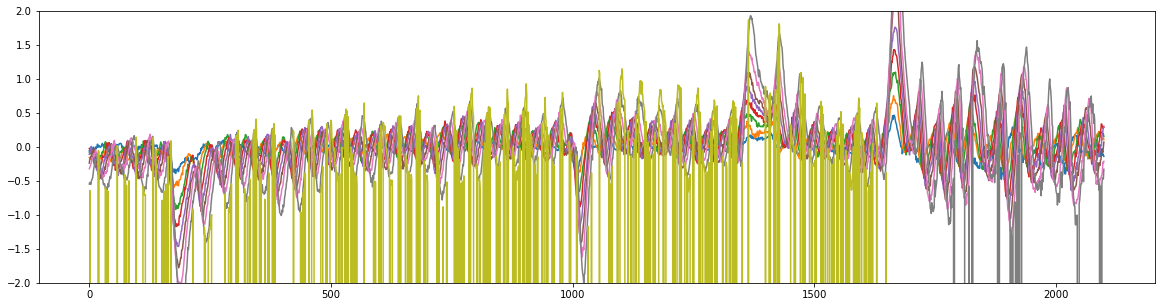

In [13]:
plt.figure(figsize=(20,5))
plt.plot(np.cumsum(tail_angle[:700*3,:],axis=1)) # Not cumulated!!!!!
plt.ylim(-2,2)

In [14]:
segmentation = Segmentation(tail_angle,fps = 700,Reference_tail_segment = 6,BCFilt = 10,MinFiltSize = 20000,MaxFiltSize = 20,Margin_std_noise = 2.)

Shape of No Track:
(11116,)


(-2, 2)

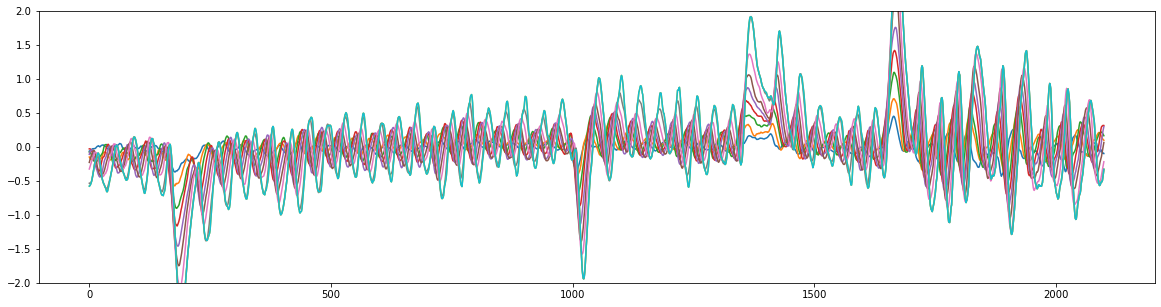

In [15]:
plt.figure(figsize=(20,5))
plt.plot(segmentation.tail_angle_smooth[:700*3,:]) # Not cumulated!!!!!
plt.ylim(-2,2)

0.05855757701909885


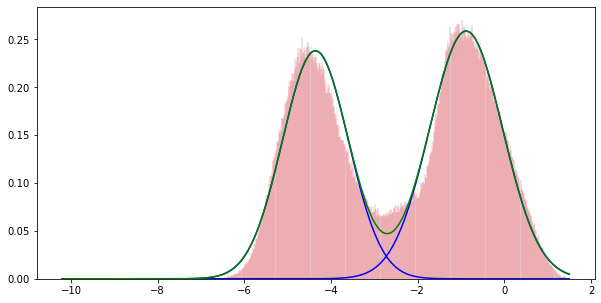

In [16]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
BoutThresh,ax = segmentation.find_activity_threshold(axis=ax)
print(BoutThresh)

In [17]:
onset,offset,tail_active = segmentation.initial_segmentation( Min_Duration = 20 , Min_IBI = 80)

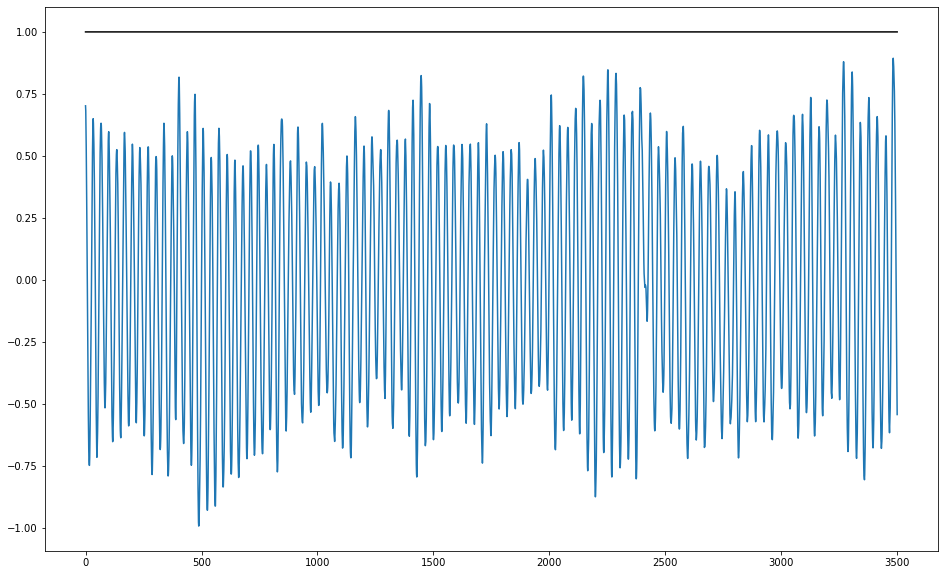

In [18]:
# Diagnostic Plot:
Duration = 700*5
IdSt = 700*60*5
ReferenceSegment=segmentation.Reference_tail_segment
#IdSt = np.random.randint(low_pass_tail_speed.shape[0]-Duration)

fig, (ax1) = plt.subplots(1,1,figsize=(16,10), sharex=True)
ax1.plot(tail_active[IdSt:IdSt+Duration],'k')
id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==1)[0]
if len(id)>0:
    ax1.scatter(id,segmentation.tail_angle_smooth[IdSt:IdSt+Duration,ReferenceSegment][id],s=50,c='b')
id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==-1)[0]
if len(id)>0:
    ax1.scatter(id,segmentation.tail_angle_smooth[IdSt:IdSt+Duration,ReferenceSegment][id],s=50,c='r')
ax1.plot(segmentation.tail_angle_smooth[IdSt:IdSt+Duration,ReferenceSegment])
plt.show()

In [19]:
segmentation.tail_angle_smooth.shape

(8747873, 10)

In [20]:
segmentation.Reference_tail_segment

6

In [39]:
peaks_pos,peaks_neg = segmentation.extract_half_beat(Half_BCFilt = 150, stdThres = 5,MinSizeBlob=500)
onset, offset, tail_active = segmentation.refine_bouts(MaxIBeatI = 50)

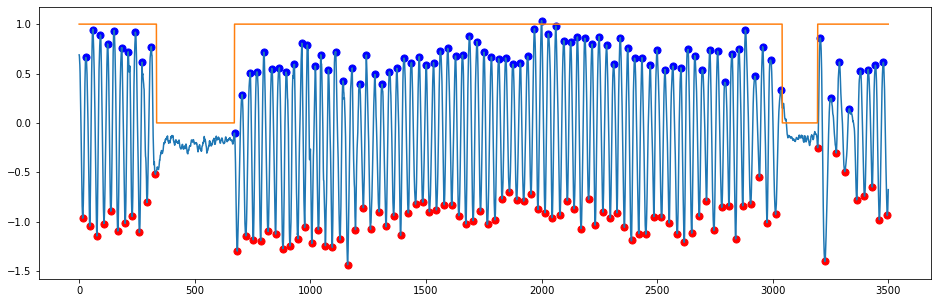

In [51]:
# Diagnostic Plot:
Duration = 700*5
IdSt = 700*60*5
IdSt = np.random.randint(segmentation.tail_angle_smooth.shape[0]-Duration)

fig, (ax1) = plt.subplots(1,1,figsize=(16,5), sharex=True)

id = peaks_pos[(peaks_pos>IdSt)&(peaks_pos<(IdSt+Duration))]-IdSt
ax1.scatter(id,segmentation.tail_angle_smooth[IdSt:IdSt+Duration,ReferenceSegment][id],s=50,c='b')

id = peaks_neg[(peaks_neg>IdSt)&(peaks_neg<(IdSt+Duration))]-IdSt
ax1.scatter(id,segmentation.tail_angle_smooth[IdSt:IdSt+Duration,ReferenceSegment][id],s=50,c='r')

ax1.plot(segmentation.tail_angle_smooth[IdSt:IdSt+Duration,ReferenceSegment])
ax1.plot(segmentation.tail_active[IdSt:IdSt+Duration])

plt.show()

# DMD Class:

# Attributes:

* Input X
* Hankel Mat H
* Control Y
* Time Shift

# Function:

* Compute Hankel
* Compute SVD
* Compute Time Shift
* Fit DMD
* Prectict from t (X)
* Predict at time lag tau
* Compute Residual


# Using DMD to segment and dissociate signal from noise

In [52]:
# Compute Hankel:
from scipy.ndimage.interpolation import shift
import scipy 

In [53]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [54]:
def svht(X, sv=None):
    # svht for sigma unknown
    m,n = sorted(X.shape) # ensures m <= n
    beta = m / n # ratio between 0 and 1
    if sv is None:
        sv = scipy.linalg.svdvals(X)
    sv = np.squeeze(sv)
    omega_approx = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
    return np.median(sv) * omega_approx


In [125]:
class DynamicModeDecomposition:
    
    def __init__(self,
                 ):
        
        self.X = None
        self.Hankel = None
        self.Y = None

        self.mu = None
        self.Phi = None
        self.U = None
        self.V = None
        self.Atil = None
        self.W = None
        self.Sig = None

    def compute_hankel(self,X,delay):
        H = np.array([])
        H = H.reshape(0,X.shape[0])
        for i in delay:
            print(i)
            H = np.concatenate((H,shift(X,(i,0), cval=0).T))#.reshape(NumSeg,tail.shape[0])))
        # Add Intercept:
        print(H.shape)
        H = np.concatenate((H,np.ones_like(H[0,:])[:,np.newaxis].T))#.reshape(NumSeg,tail.shape[0])))
        
        Y = shift(H,(0,-1), cval=0) 
        
        self.X = X
        self.Y = Y
        self.H = H
        return H,Y
    
    def compute_singular_value(self,axis=None):
        # determine rank-reduction
        sv = scipy.linalg.svdvals(self.H)
        tau = svht(self.H, sv=sv)
        r = sum(sv > tau)
        print("rank",r)
        axis.scatter(range(1, len(sv)+1), sv, s=5)
        axis.axhline(tau, c='r')
        axis.set_xlim([0.9,min(len(sv),100)])
        return r,axis
    
    def fit(self,truncate):
        U2,Sig2,Vh2 = np.linalg.svd(self.H, False) # SVD of input matrix
        r = len(Sig2) if truncate is None else truncate # rank truncation
        self.r = r
        U = U2[:,:r]
        Sig = np.diag(Sig2)[:r,:r]
        V = Vh2.conj().T[:,:r]
        Atil = U.conj().T.dot(self.Y).dot(V).dot(np.linalg.inv(Sig)) # build A tilde
        mu,W = np.linalg.eig(Atil)
        Phi = self.Y.dot(V).dot(np.linalg.inv(Sig)).dot(W) # build DMD modes
        self.mu = mu
        self.Phi = Phi
        self.U = U
        self.V = V
        self.Atil = Atil
        self.W = W
        self.Sig = Sig
        self.Vand = np.vander(mu, np.max(self.X.shape), True)  

    def predict(self,t_,horizon=700):
        b = np.dot(np.linalg.pinv(self.Phi), self.H[:,t_])
        Psi = (self.Vand[:,:horizon].T * b).T
        H_pred = np.dot(self.Phi, Psi)
        return H_pred

    def continous_prediction(self,tau):
        b = np.dot(np.linalg.pinv(self.Phi), self.H)
        Vand_tau = self.Vand[:,tau].reshape(-1,1)
        X_Prediction_tau = self.Phi.dot(Vand_tau*b)
        X_shifted_tau = shift(self.H,(0,-tau), cval=0) #36 correspond to average inter-peak distance
        return X_Prediction_tau,X_shifted_tau

    def display_spectrum_complex(self,axis):
        theta = np.linspace(0, 2*np.pi, 100)
        radius = 1
        a = radius*np.cos(theta)
        b = radius*np.sin(theta)
        axis.plot(a, b, '--k')
        axis.scatter(np.real(self.mu), np.imag(self.mu))
        axis.grid()
        axis.set_aspect(1)
        return axis

    def display_spectrum(self,axis):
        lambda_ = np.log(self.mu)/(1/700)
        axis.scatter(np.imag(lambda_)/(2*np.pi),-1e3*(1/np.real(lambda_)))
        axis.set_ylabel(r'$\tau$ (ms)')
        axis.set_xlabel('frequency (Hz)')
        return axis
    
    def decompose_into_mode(self):
        b = np.dot(np.linalg.pinv(self.Phi), self.H)
        X_factored = np.zeros((self.r,b.shape[1]),dtype=complex)
        for i in range(X_factored.shape[0]):
            X_factored[i,:] = b[i,:]*self.Phi[0,i]
        return X_factored

In [126]:
segmentation.tail_angle_smooth.shape

(8747873, 10)

In [127]:
tail = segmentation.tail_angle_smooth[:1000000,2:7]
print(tail.shape)

(1000000, 5)


In [128]:
dmd = DynamicModeDecomposition()

In [129]:
tail.shape

(1000000, 5)

In [130]:
H,Y = dmd.compute_hankel(tail,[i for i in range(0,5,1)])

0
1
2
3
4
(25, 1000000)


In [131]:
dmd.X.shape

(1000000, 5)

In [132]:
dmd.H.shape

(26, 1000000)

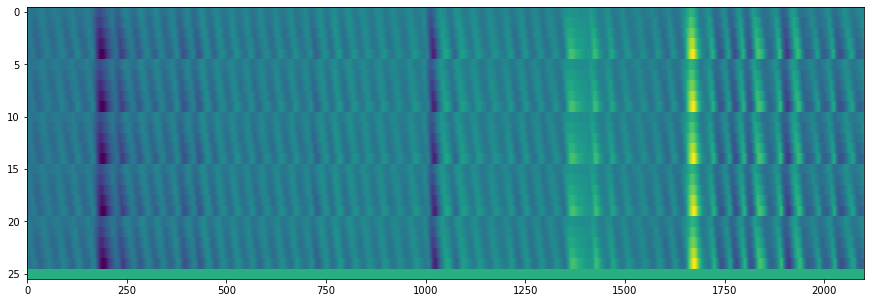

In [133]:
plt.figure(figsize=(15,5))
plt.imshow(dmd.H[:,:700*3],aspect='auto')
plt.show()

In [134]:
tail.shape

(1000000, 5)

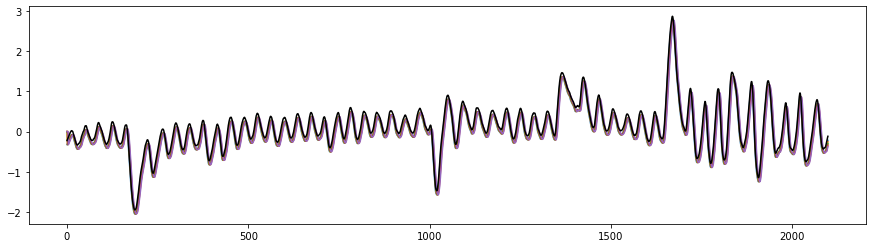

In [135]:
plt.figure(figsize=(15,4))
plt.plot(dmd.H[4:-1:5,:700*3].T)
plt.plot(tail[:700*3,-1]+0.1,'k')
plt.show()

rank 12


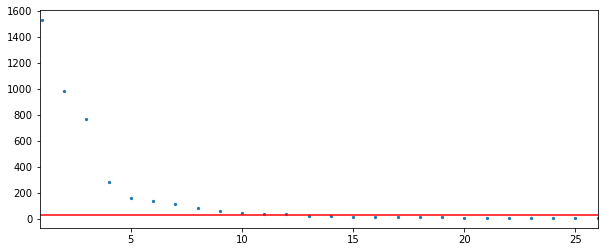

In [136]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax = dmd.compute_singular_value(ax)
plt.show()  

In [137]:
dmd.fit(4)

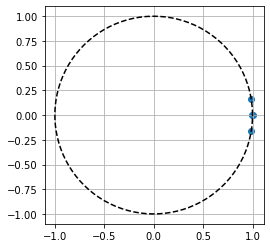

In [138]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax = dmd.display_spectrum_complex(ax)
plt.show()  

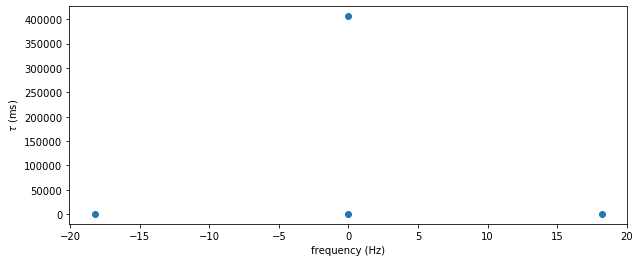

In [139]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax = dmd.display_spectrum(ax)
plt.show()  

In [140]:
t_ = 600
H_pred = dmd.predict(t_,horizon=700)

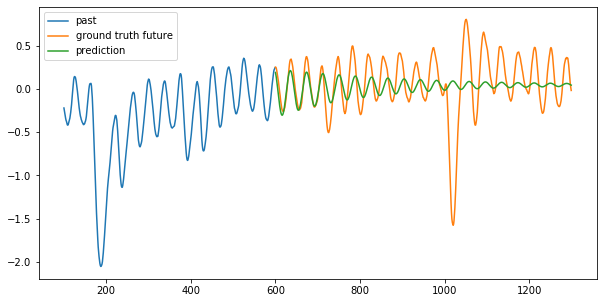

In [141]:
plt.figure(figsize=(10,5))
s = 4
t_past = np.arange(max(0,t_-500),t_)#np.arange(X[0,:t_].shape[0])
plt.plot(t_past,dmd.H[s,max(0,t_-500):t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,dmd.H[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,H_pred[s,:],label='prediction')
plt.legend()

In [240]:
tau = 15
H_Prediction_tau,H_shifted_tau = dmd.continous_prediction(tau)

In [241]:
H_Prediction_tau = np.real(H_Prediction_tau)

In [242]:
error = np.power(np.abs(H_shifted_tau[s,:]-H_Prediction_tau[s,:]),2)
#error = np.mean(error,axis=0)

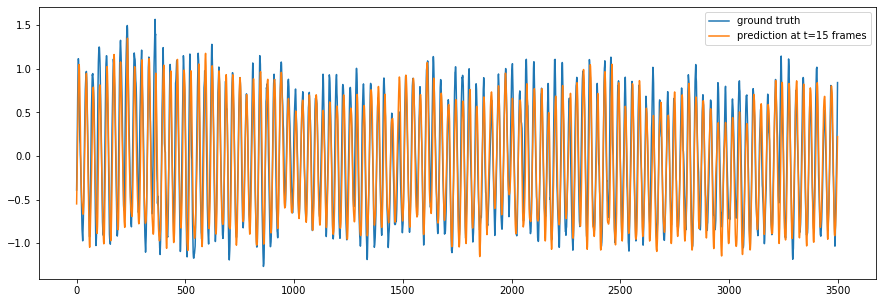

In [243]:
IdSt = np.random.randint(H_Prediction_tau.shape[1]-Duration)
Duration = 700*5

fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(H_shifted_tau[s,IdSt:IdSt+Duration],label='ground truth')
ax.plot(H_Prediction_tau[s,IdSt:IdSt+Duration],label='prediction at t={} frames'.format(tau))
plt.legend()

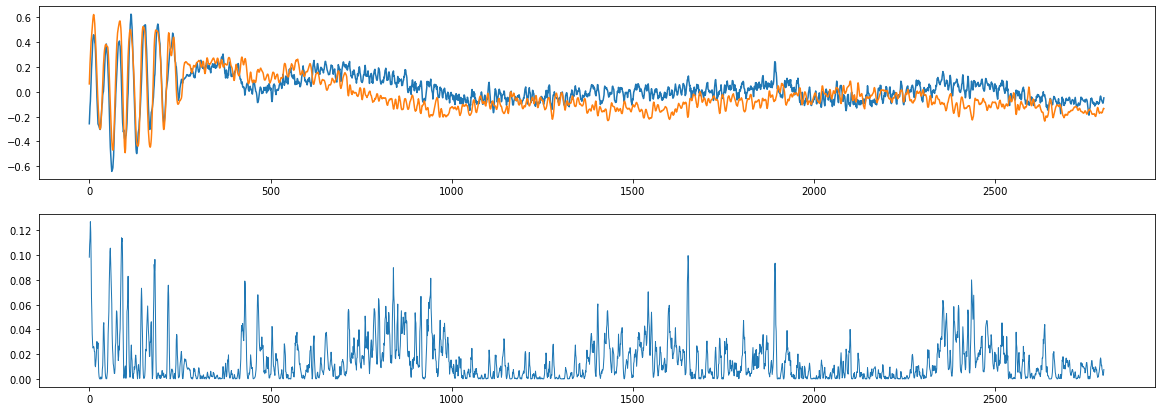

In [266]:
IdSt = np.random.randint(H_Prediction_tau.shape[1]-Duration)
Duration = 700*4

fig,ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(H_shifted_tau[s,IdSt:IdSt+Duration])
ax[0].plot(H_Prediction_tau[s,IdSt:IdSt+Duration])
ax[1].plot(np.log(1+error[IdSt:IdSt+Duration]),lw=1)


In [249]:
latent_mode = dmd.decompose_into_mode()

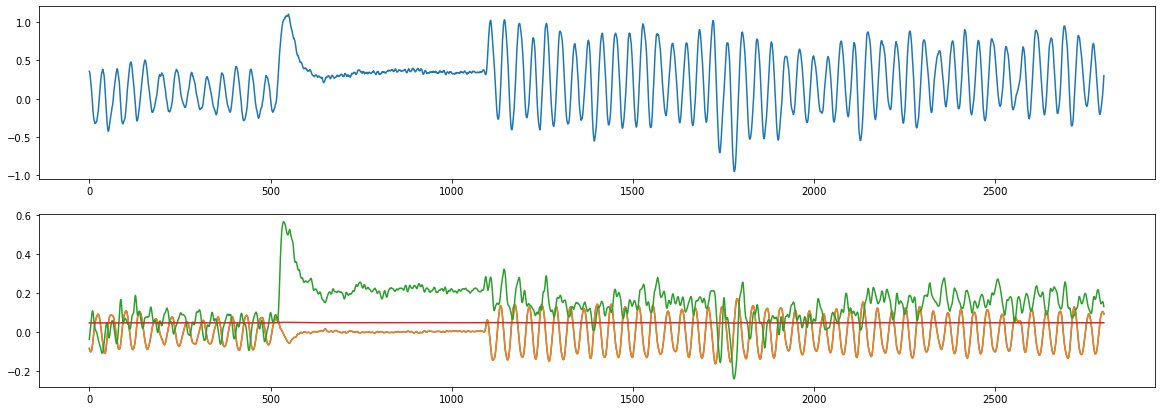

In [259]:
IdSt = np.random.randint(dmd.H.shape[1]-Duration)
Duration = 700*4

fig,ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(dmd.H[s,IdSt:IdSt+Duration])

ax[1].plot(latent_mode[:,IdSt:IdSt+Duration].T)
plt.show()

In [267]:
all_peaks = np.concatenate((segmentation.half_beat_pos,segmentation.half_beat_neg))
all_peaks = np.sort(all_peaks)
all_peaks = all_peaks-tau

In [268]:
H_shifted_tau.shape

(26, 1000000)

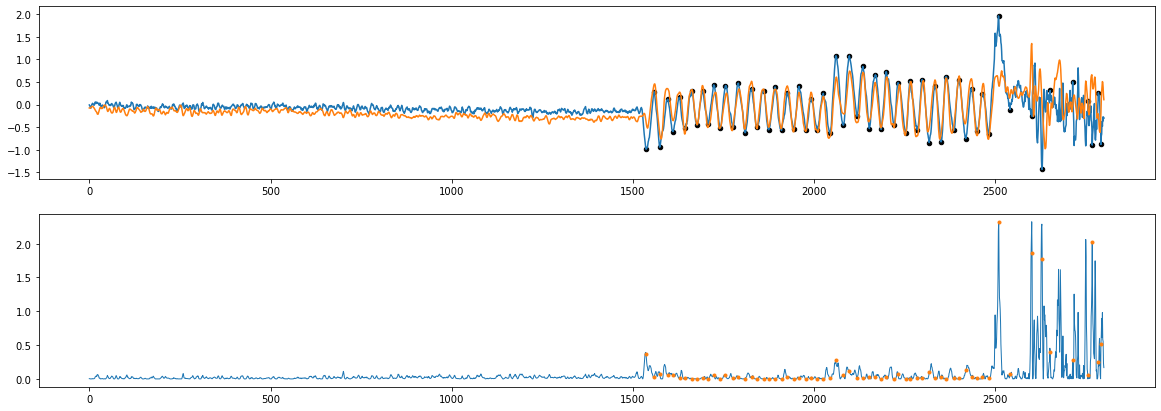

In [269]:
IdSt = np.random.randint(H_Prediction_tau.shape[1]-Duration)
Duration = 700*4
peak = all_peaks[(all_peaks>IdSt)&(all_peaks<(IdSt+Duration))]-IdSt

s = 4
fig,ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(H_shifted_tau[s,IdSt:IdSt+Duration])
ax[0].plot(H_Prediction_tau[s,IdSt:IdSt+Duration])
ax[0].scatter(peak,H_shifted_tau[s,IdSt:IdSt+Duration][peak],s=20,c='k')

#ax[1].plot(np.log(1+error[IdSt:IdSt+Duration]),lw=1)
#ax[1].plot(peak,np.log(1+error[IdSt:IdSt+Duration])[peak],'.')

#ax[1].plot(error[IdSt:IdSt+Duration],lw=1)
ax[1].plot(moving_average(error[IdSt:IdSt+Duration],1),lw=1)
ax[1].plot(peak,moving_average(error[IdSt:IdSt+Duration],1)[peak],'.')
#ax[1].hlines(0.25,0,Duration)


In [170]:
np.exp(-5)*np.max(error)

0.07429838291401589

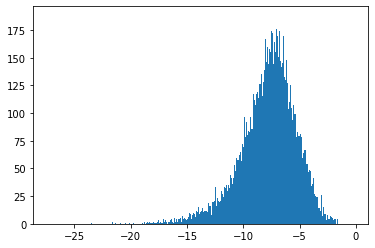

In [1002]:
plt.hist(np.log(error[all_peaks[all_peaks<len(error)]]/np.max(error)),1000)
#plt.xlim(0,0.5)
plt.show()

### For each bouts of activity:
    * Define max number of bouts given the duration
    
    * Find largest peak -> Define as bout start
    
    * For each of the sorted bouts peak find if it is preceeded by a larger peak or too close to the end = > Define as bout start
    
    * 
    

In [910]:
segmentation.onset

array([     27,   55336,   57487, ..., 8742975, 8743854, 8744152],
      dtype=int64)

In [911]:
segmentation.offset

array([   2119,   57028,   58340, ..., 8743630, 8744063, 8744223],
      dtype=int64)

In [912]:
segmentation.half_beat_pos

array([     53,      87,     125, ..., 8744153, 8744178, 8744224])

In [ ]:
# Sort all largest value of error[peak] inside a bouts
# If the value is inside a bouts

# Fitting dynamical system with noise

In [ ]:
def compute_future_V_withNoise(V0,A,N,covariance_u):
    Vfuture = np.zeros((len(V0),N))
    Vfuture[:,0] = V0
    for i in range(1,N):
        noise = np.random.multivariate_normal(np.zeros(covariance_u.shape[1]), covariance_u, size=None, check_valid='warn', tol=1e-8)
        Vfuture[:,i] = A@Vfuture[:,i-1] + 1*noise
    return Vfuture

In [ ]:
# For every time-point compute prediction error in T_step:
dt = 1/700
u = np.zeros((X.shape[1],V.shape[1]))
for i in range(700*60*5):#X.shape[1]):
    if i%(700*60)==0:
        print(i/(700*60*5))
    
    V_pred = A_fromV@V[i,:].T
    V_true = V[i+1,:]
    u[i,:] = (V_true-V_pred)#/dt
    # A@Vfuture[:,i-1]
    

In [ ]:
covariance_u = u[:700*60*5,:].T@u[:700*60*5,:]/u[:700*60*5,:].shape[0]

In [ ]:
t_ = 500#*60*4+700*3

N = 70

plt.plot(np.arange(-200,0),V[t_-200:t_,1])
plt.plot(np.arange(N),V[t_:t_+N,1],'b--')

for i in range(10):
    
    Vfuture = compute_future_V_withNoise(V[t_,:],A_fromV,N,covariance_u)
    plt.plot(np.arange(N),Vfuture[1,:],'r',lw=1)
    
plt.show()

# Fitting specific dynamical system for each bouts:

In [270]:
dmd.V.shape

(1000000, 4)

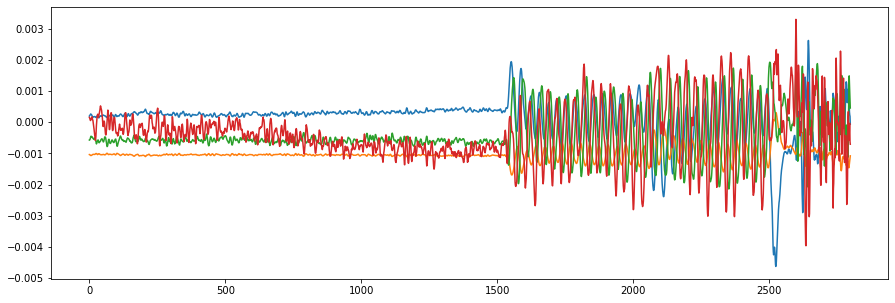

In [271]:
#IdSt = np.random.randint(H_Prediction_tau.shape[1]-Duration)
Duration = 700*4
s = 4
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(dmd.V[IdSt:IdSt+Duration,:5])

In [406]:
all_peaks = np.concatenate((segmentation.half_beat_pos,segmentation.half_beat_neg))
all_peaks = np.sort(all_peaks)
all_peaks = all_peaks[all_peaks<dmd.V.shape[0]]


<ipython-input-439-fbe24f682912>:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  res = np.linalg.lstsq(V[0:-1], V[1:], rcond='warn')


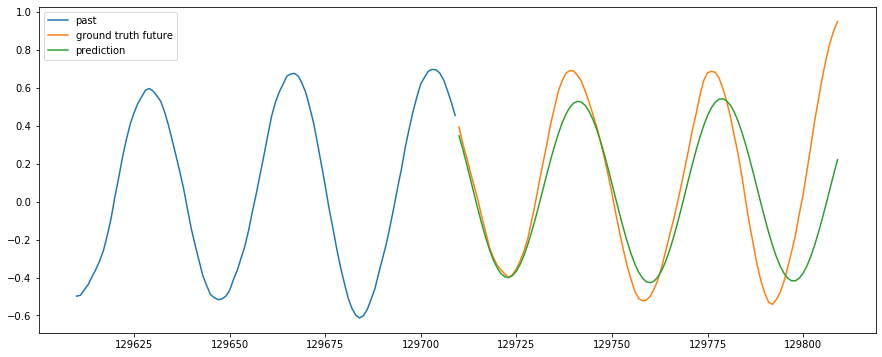

In [439]:
onset_fit = all_peaks[np.random.randint(len(all_peaks))]#np.random.randint(H_Prediction_tau.shape[1]-Duration)#1350
offset_fit = onset_fit+100#1535
horizon = 100

all_ones = np.ones(dmd.V.shape[0])[:,np.newaxis]

V_w_intercept = np.concatenate((dmd.V.T,all_ones.T)).T
#linalg.lstsq(a, b, rcond='warn')
V = V_w_intercept[onset_fit:offset_fit,:]
res = np.linalg.lstsq(V[0:-1], V[1:], rcond='warn')
A_fromV,residual = res[0].T,res[1] # Transpose is crutial to match Atil

V_0 =  np.array(dmd.V[offset_fit,:].tolist()+[1])
V_predicted = np.zeros((horizon,V.shape[1]))
V_predicted[0,:] = V_0
for i in range(1,horizon):
    V_predicted[i,:] = A_fromV@V_predicted[i-1,:]# Atil does not work here
    
H_predicted = dmd.U@dmd.Sig@V_predicted[:,:-1].T

plt.figure(figsize=(15,6))
s = 4
t_past = np.arange(onset_fit,offset_fit)#np.arange(X[0,:t_].shape[0])
plt.plot(t_past,dmd.H[s,onset_fit:offset_fit],label='past')
t_future = np.arange(offset_fit,offset_fit+horizon)
plt.plot(t_future,dmd.H[s,offset_fit:offset_fit+horizon],label='ground truth future')
plt.plot(t_future,H_predicted[s,:],label='prediction')
plt.legend()
plt.show()

<ipython-input-451-3094b62303a7>:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  res = np.linalg.lstsq(V[0:-1], V[1:], rcond='warn')


"\n        plt.figure(figsize=(15,6))\n        s = 4\n        t_past = np.arange(onset_fit,offset_fit)#np.arange(X[0,:t_].shape[0])\n        plt.plot(t_past,dmd.H[s,onset_fit:offset_fit],label='past')\n        t_future = np.arange(offset_fit,offset_fit+horizon)\n        plt.plot(t_future,dmd.H[s,offset_fit:offset_fit+horizon],label='ground truth future')\n        plt.plot(t_future,H_predicted[s,:],label='prediction')\n        plt.legend()\n        plt.show()\n"

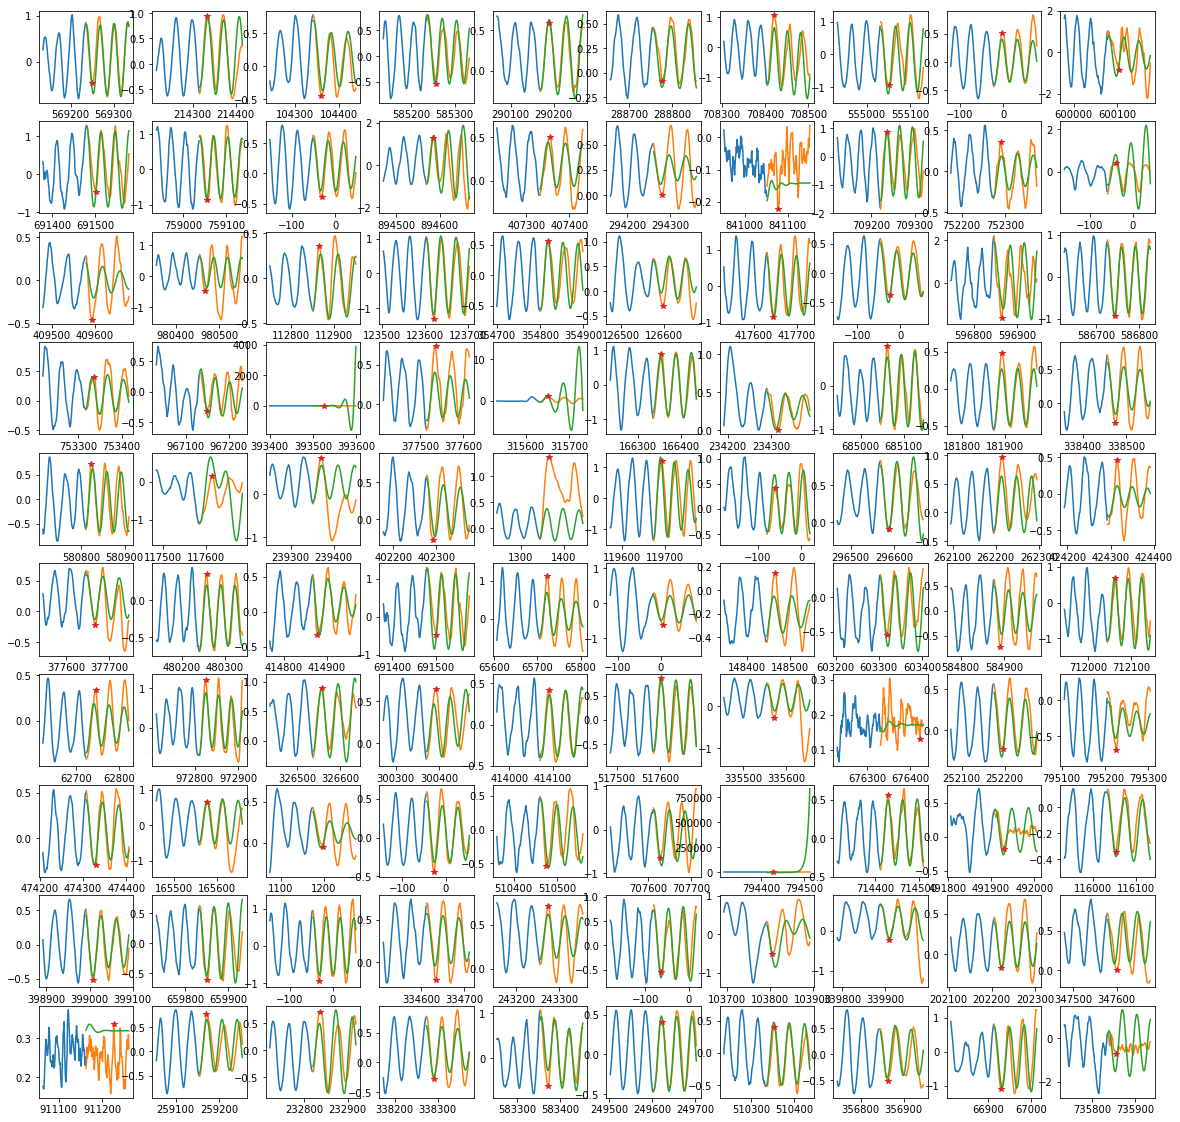

In [451]:
f,ax = plt.subplots(10,10,figsize=(20,20))

for ii in range(10):
    for jj in range(10):
        kk = np.random.randint(len(all_peaks))
        onset_fit = all_peaks[kk]-100#np.random.randint(H_Prediction_tau.shape[1]-Duration)#1350
        offset_fit = all_peaks[kk]#1535
        horizon = 100

        all_ones = np.ones(dmd.V.shape[0])[:,np.newaxis]

        V_w_intercept = np.concatenate((dmd.V.T,all_ones.T)).T
        #linalg.lstsq(a, b, rcond='warn')
        V = V_w_intercept[onset_fit:offset_fit,:]
        res = np.linalg.lstsq(V[0:-1], V[1:], rcond='warn')
        A_fromV,residual = res[0].T,res[1] # Transpose is crutial to match Atil

        V_0 =  np.array(dmd.V[offset_fit,:].tolist()+[1])
        V_predicted = np.zeros((horizon,V.shape[1]))
        V_predicted[0,:] = V_0
        for i in range(1,horizon):
            V_predicted[i,:] = A_fromV@V_predicted[i-1,:]# Atil does not work here
            
        H_predicted = dmd.U@dmd.Sig@V_predicted[:,:-1].T
        
        s = 4
        t_past = np.arange(onset_fit,offset_fit)#np.arange(X[0,:t_].shape[0])
        ax[ii,jj].plot(t_past,dmd.H[s,onset_fit:offset_fit],label='past')
        t_future = np.arange(offset_fit,offset_fit+horizon)
        ax[ii,jj].plot(t_future,dmd.H[s,offset_fit:offset_fit+horizon],label='ground truth future')
        ax[ii,jj].plot(t_future,H_predicted[s,:],label='prediction')
        ax[ii,jj].plot(all_peaks[kk+1],dmd.H[s,all_peaks[kk+1]],'*')
        #plt.legend()
#plt.show()

'''
        plt.figure(figsize=(15,6))
        s = 4
        t_past = np.arange(onset_fit,offset_fit)#np.arange(X[0,:t_].shape[0])
        plt.plot(t_past,dmd.H[s,onset_fit:offset_fit],label='past')
        t_future = np.arange(offset_fit,offset_fit+horizon)
        plt.plot(t_future,dmd.H[s,offset_fit:offset_fit+horizon],label='ground truth future')
        plt.plot(t_future,H_predicted[s,:],label='prediction')
        plt.legend()
        plt.show()
'''

In [364]:
onset_fit = 500
offset_fit = 500000

horizon = 700

Atil = dmd.U.conj().T.dot(dmd.Y[:,onset_fit:offset_fit]).dot(dmd.V[onset_fit:offset_fit,:]).dot(np.linalg.inv(dmd.Sig)) # build A tilde
mu,W = np.linalg.eig(Atil)
Phi = dmd.Y[:,onset_fit:offset_fit].dot(dmd.V[onset_fit:offset_fit,:]).dot(np.linalg.inv(dmd.Sig)).dot(W) # build DMD modes
Vand = np.vander(mu, horizon, True)  


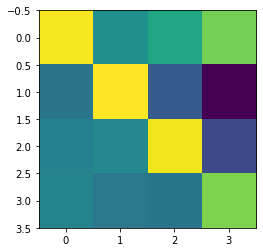

In [365]:
plt.imshow(Atil)

In [366]:
mu

array([0.47991362+0.05776209j, 0.47991362-0.05776209j,
       0.42006314+0.j        , 0.20553384+0.j        ])

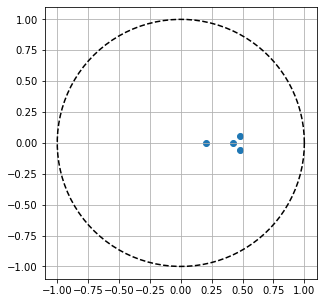

In [367]:
fig,axis = plt.subplots(1,1,figsize=(5,5))
theta = np.linspace(0, 2*np.pi, 100)
radius = 1
a = radius*np.cos(theta)
b = radius*np.sin(theta)
axis.plot(a, b, '--k')
axis.scatter(np.real(mu), np.imag(mu))
axis.grid()
axis.set_aspect(1)

In [368]:
Phi.shape

(50, 4)

In [369]:
b = np.dot(np.linalg.pinv(Phi), dmd.H[:,offset_fit])
Psi = (Vand.T * b).T
H_pred = np.dot(Phi, Psi)


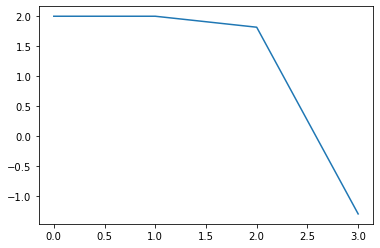

In [370]:
plt.plot(b)

In [371]:
H_pred.shape

(50, 700)

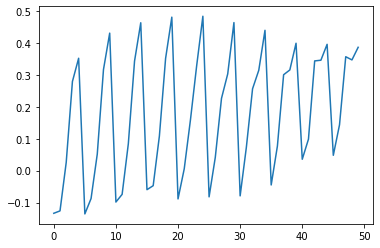

In [373]:
plt.plot(dmd.H[:,offset_fit])

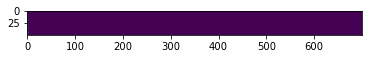

In [374]:
plt.imshow(np.abs(H_pred))

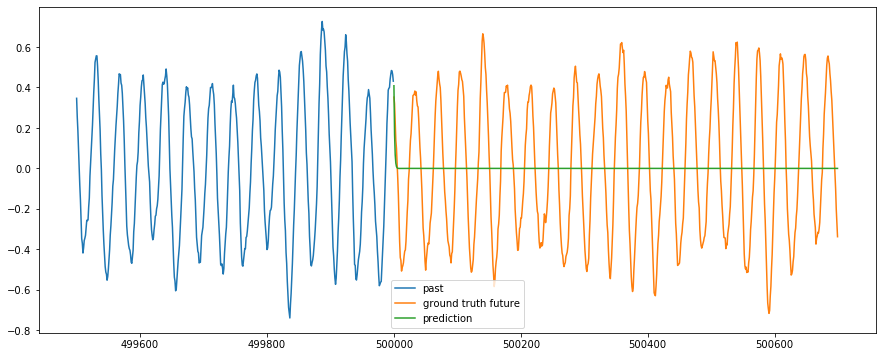

In [375]:
plt.figure(figsize=(15,6))
s = 4
t_past = np.arange(max(0,offset_fit-onset_fit),offset_fit)#np.arange(X[0,:t_].shape[0])
plt.plot(t_past,dmd.H[s,offset_fit-500:offset_fit],label='past')
t_future = np.arange(offset_fit,offset_fit+700)
plt.plot(t_future,dmd.H[s,offset_fit:offset_fit+700],label='ground truth future')
plt.plot(t_future,H_pred[s,:],label='prediction')
plt.legend()
plt.show()

# Compute Error During Half Beat:

In [229]:
all_peaks = np.concatenate((segmentation.half_beat_pos,segmentation.half_beat_neg))
all_peaks = np.sort(all_peaks)
all_peaks = all_peaks-tau
all_peaks = all_peaks[all_peaks<len(error)]
surprise = np.log(1+error[all_peaks])

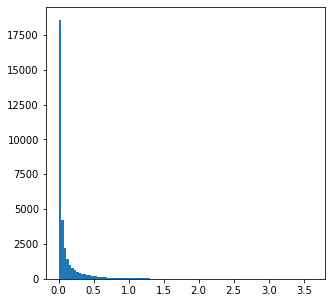

In [51]:
plt.figure(figsize=(5,5))
plt.hist(surprise,100)
plt.show()

In [ ]:
np.exp(-5)

In [ ]:
all_peaks = all_peaks[surprise>np.exp(-4)]
surprise = surprise[surprise>np.exp(-4)]

In [ ]:
IdSt = np.random.randint(H_Prediction_tau.shape[1]-Duration)#700*30#
Duration = 700*4

plt.figure(figsize=(15,5))
plt.plot(H_shifted_tau[s,:])
plt.plot(H_Prediction_tau[s,:],'--')
plt.plot(error,lw=5,alpha=0.3)
#plt.scatter(all_peaks,5*surprise,c='r')
plt.xlim(IdSt,IdSt+Duration)
plt.ylim(-1,1)

In [ ]:
X = np.log(surprise)[:,np.newaxis]
margin_std = 3
gm = GaussianMixture(n_components=2, random_state=0).fit(X)

weights = gm.weights_
means = gm.means_
covars = gm.covariances_

id = np.argmin(means)

sigma  = np.sqrt(covars[id]) # Standard Deviation
BoutThresh = np.exp(means[id] + margin_std*sigma)[0]

f_axis = X.copy().ravel()
f_axis.sort()

f,axis = plt.subplots(1,1,figsize=(10,5))
axis.hist(X, bins=1000, histtype='bar', density=True, ec='red', alpha=0.1)
#axis.plot(bins,count)
axis.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='blue')
axis.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='blue')
axis.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel()+weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(),
c='green')

In [ ]:
BoutThresh

In [ ]:
# determine rank-reduction
sv = scipy.linalg.svdvals(X)
tau = svht(X, sv=sv)
r = sum(sv > tau)
print("rank",r)
fig, ax = plt.subplots()
ax.scatter(range(1, len(sv)+1), sv, s=5)
ax.axhline(tau, c='r')
ax.set_xlim([0.9,100])

In [ ]:
r = 29

In [ ]:
# do dmd
mu, Phi,U,V,Atil,W,Sig = dmd_fit(X, Y, r)
# compute time evolution
#b = np.dot(np.linalg.pinv(Phi), X[:,0])
Vand = np.vander(mu, np.max(X.shape), True)
#Psi = (Vand.T * b).T

In [ ]:
theta = np.linspace(0, 2*np.pi, 100)

radius = 1
a = radius*np.cos(theta)
b = radius*np.sin(theta)

figure, ax = plt.subplots(1)
ax.plot(a, b, '--k')
ax.scatter(np.real(mu), np.imag(mu))
ax.grid()
ax.set_aspect(1)

In [ ]:
lambda_ = np.log(mu)/(1/700)
plt.scatter(np.imag(lambda_)/(2*np.pi),-1e3*(1/np.real(lambda_)))
plt.ylabel(r'$\tau$ (ms)')
plt.xlabel('frequency (Hz)')

In [ ]:
t_ = 10300
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(max(0,t_-500),t_)#np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,max(0,t_-500):t_],label='past')

t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

In [ ]:
Vand.shape

In [ ]:
t_ = 10200
X_pred = predict_with_DMD(X[:,t_],Vand[:,:700],Phi)

In [ ]:

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(max(0,t_-500),t_)#np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,max(0,t_-500):t_],label='past')

t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_pred[s,:],label='prediction')
plt.legend()

In [ ]:
s = 6
X_Prediction_tau,X_shifted_tau = continous_prediction_with_DMD(X[:,:100000],Phi,Vand,15)

IdSt = np.random.randint(X_Prediction_tau.shape[1]-Duration)
Duration = 700*4
plt.figure(figsize=(15,5))
plt.plot(X_shifted_tau[s,IdSt:IdSt+Duration])
plt.plot(X_Prediction_tau[s,IdSt:IdSt+Duration])


In [ ]:
error = np.power(np.abs(X_shifted_tau-X_Prediction_tau),2)
error = np.mean(error,axis=0)

In [ ]:
err = []
for tau in range(1,90,3):
    print(tau)
    X_Prediction_tau,X_shifted_tau = continous_prediction_with_DMD(X[:,:100000],Phi,Vand,tau)
    error = np.power(np.abs(X_shifted_tau-X_Prediction_tau),2)
    error = np.mean(error,axis=0)
    err.append(np.mean(error))

In [ ]:
plt.plot(np.arange(1,90,3),err)

In [ ]:
plt.plot(np.arange(1,90,3),err)

In [ ]:
plt.plot(np.arange(1,90,3),err)

In [ ]:
error.shape

In [ ]:
IdSt = np.random.randint(b.shape[1]-Duration)
Duration = 700*4
plt.plot(X[6,IdSt:IdSt+Duration])
plt.plot(10*error[IdSt:IdSt+Duration])


In [ ]:
# Mode Decomposition:
b = np.dot(np.linalg.pinv(Phi), X[:,:100000])
X_factored = np.zeros((r,b.shape[1]),dtype=complex)
for i in range(b.shape[0]):
    X_factored[i,:] = b[i,:]*Phi[0,i]


In [ ]:
IdSt = np.random.randint(b.shape[1]-Duration)
Duration = 700*3

fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot(211)
ax1.plot(smooth_cumul_tail_angle[IdSt:IdSt+Duration,:])

ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(np.real(X_factored[:,IdSt:IdSt+Duration].T))
plt.show()

plt.figure(figsize=(10,3))
plt.imshow(np.real(X_factored[:,IdSt:IdSt+Duration]),aspect='auto')
plt.show()



In [ ]:
# Compute Hankel:
from scipy.ndimage.interpolation import shift

NumSeg = 7
tail = smooth_cumul_tail_angle[:1000000,NumSeg]
#tail = tail - np.mean(tail)
tail = tail - moving_average(tail,700*5)
# Low Pass Tail:
tail = tail[:,np.newaxis]

X = np.array([])
X = X.reshape(0,tail.shape[0])
for i in range(0,60,2):
    print(i)
    X = np.concatenate((X,shift(tail,(i,0), cval=0).T))#.reshape(NumSeg,tail.shape[0])))
    
Y = shift(X,(0,-1), cval=0) #36 correspond to average inter-peak distance




In [ ]:
# Fit DMD:


In [ ]:
import scipy 
# determine rank-reduction
sv = scipy.linalg.svdvals(X)
tau = svht(X, sv=sv)
r = sum(sv > tau)
print("rank",r)
fig, ax = plt.subplots()
ax.scatter(range(1, len(sv)+1), sv, s=5)
ax.axhline(tau, c='r')
ax.set_xlim([0.9,100])

In [ ]:
r = 12

In [ ]:
# do dmd
mu, Phi,U,V,Atil,W,Sig = dmd_(X, Y, r)
# compute time evolution
#b = np.dot(np.linalg.pinv(Phi), X[:,0])
Vand = np.vander(mu, np.max(X.shape), True)
#Psi = (Vand.T * b).T

# Analysis of A

In [ ]:
theta = np.linspace(0, 2*np.pi, 100)

radius = 1
a = radius*np.cos(theta)
b = radius*np.sin(theta)

figure, ax = plt.subplots(1)
ax.plot(a, b, '--k')
ax.scatter(np.real(mu), np.imag(mu))
ax.grid()
ax.set_aspect(1)

In [ ]:
lambda_ = np.log(mu)/(1/700)

In [ ]:
lambda_ = np.log(mu)/(1/700)
plt.scatter(1e3*(1/np.real(lambda_)),np.imag(lambda_)/(2*np.pi))
plt.xlabel(r'$\tau$ (ms)')
plt.ylabel('frequency (Hz)')

In [ ]:
lambda_ = np.log(mu)/(1/700)
plt.scatter(np.imag(lambda_)/(2*np.pi),1e3*(1/np.real(lambda_)),)
plt.xlabel(r'$\tau$ (ms)')
plt.ylabel('frequency (Hz)')

In [ ]:
Phi.shape

In [ ]:
r

In [ ]:
Power = np.power(np.linalg.norm(Phi,axis=0),2)

In [ ]:
lambda_ = np.log(mu)
dt = (1/700)
fi = np.imag(lambda_/dt)/(2*np.pi)

In [ ]:
plt.scatter(fi[fi>=0],Power[fi>=0])

# Predict



In [ ]:
Phi.shape

In [ ]:
X.shape

In [ ]:
b = np.dot(np.linalg.pinv(Phi), X)

In [ ]:
b.shape

In [ ]:
IdSt = np.random.randint(b.shape[1]-Duration)
Duration = 700*3

fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot(211)
ax1.plot(smooth_cumul_tail_angle[IdSt:IdSt+Duration,:])

ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(b[:,IdSt:IdSt+Duration].T)

plt.show()

In [ ]:
Phi.shape

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(np.abs(np.linalg.pinv(Phi)))

In [ ]:
t_ = 500
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

In [ ]:
t_ = 200
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

In [ ]:
t_ = 1030
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

In [ ]:
t_ = 10300
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(max(0,t_-500),t_)#np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,max(0,t_-500):t_],label='past')

t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

In [ ]:
t_ = 520
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

In [ ]:
plt.figure(figsize=(10,4))
plt.imshow(np.real(Psi[:,:700]),aspect='auto')

In [ ]:
Vand.shape

In [ ]:
plt.figure(figsize=(10,4))
plt.imshow(np.real(Vand[:,:700]),aspect='auto')

In [ ]:
plt.plot(b)

# Dynamical System in SVD

In [ ]:
A_v = np.linalg.inv(Sig).dot(Atil).dot(Sig)

In [ ]:
plt.imshow(Sig)

In [ ]:
plt.imshow(A_v)
plt.colorbar()

In [ ]:
A_v_continuous = (A_v - np.eye(A_v.shape[0]))/dt

In [ ]:
plt.imshow(A_v_continuous,vmin=-np.max(A_v_continuous),vmax=np.max(A_v_continuous))
plt.colorbar()

In [ ]:
U.shape

In [ ]:
# are U polynomials:
plt.figure(figsize=(10,4))
plt.imshow(U.T)

In [ ]:
plt.plot(U[:,0:5])

# Using sHAVOK

In [ ]:
X.shape

In [ ]:

import numpy as np
import scipy.io as sio
from scipy import interpolate
from scipy import signal

def sHAVOK(X, dt, r, norm):
    X1 = X[:,:-1]
    X2 = X[:,1:]
    U1,_,Vh1 = np.linalg.svd(X1,full_matrices=False)
    U2,_,Vh2 = np.linalg.svd(X2,full_matrices=False)
    V1 = Vh1.T
    V2 = Vh2.T
    polys = true_polys(X.shape[0], dt, r, center=False)
    for _i in range(r):
        if (np.dot(U1[:,_i], polys[:,_i]) < 0):
            V1[:,_i] *= -1
        if (np.dot(U2[:,_i], polys[:,_i]) < 0):
            V2[:,_i] *= -1
    A = ((V2.T @ V1)[:r,:r] - np.eye(r)) / (norm * dt)
    return A


def true_polys(rows, dt, r, center): 
    m = rows // 2
    Ut = np.linspace(-m*dt, m*dt, rows)
    poly_stack = []
    for j in range(r):
        if (center):
            poly_stack.append(Ut ** (j + 1))
        else: 
            poly_stack.append(Ut ** j)
    poly_stack = np.vstack(poly_stack).T
    Q = np.empty((rows, r)) # Perform Gram-Schmidt
    for j in range(r): 
        v = poly_stack[:, j]
        for k in range(j - 1): 
            r_jk = Q[:, k].T @ poly_stack[:, j]
            v -= (r_jk * Q[:, k])
        r_jj = np.linalg.norm(v)
        Q[:, j] = v / r_jj
    return Q

def reconstruct_v(A, Vh_full, r, dt):
    Ā = A[:-1, :-1]
    B = A[:-1, -1].reshape(-1, 1)
    t0 = np.arange(Vh_full.shape[1]) * dt 
    sys = signal.StateSpace(Ā, B, np.eye(r-1), np.zeros(r-1).reshape(-1, 1))
    tout, y, x = signal.lsim(sys, Vh_full[r-1, :], t0, X0=Vh_full[:r-1, 0])
    Vh_rec = y.T
    return Vh_rec


In [ ]:
X.shape

In [ ]:
r

In [ ]:
A = sHAVOK(X,1/700,r,norm=1)

In [ ]:
plt.imshow(A)

In [ ]:
U,Sig,Vh = np.linalg.svd(X, False) # SVD of input matrix

In [ ]:
t_ = 1030
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

In [ ]:
Vh.shape

In [ ]:
r

In [ ]:
X.shape

In [ ]:
plt.imshow(A)
plt.colorbar()

In [ ]:
r

In [ ]:
A.shape

In [ ]:
B = A[:-1, -1].reshape(-1, 1)

In [ ]:
Ā = A[:-1, :-1]

In [ ]:
plt.imshow(Ā)

In [ ]:
plt.imshow(B)

In [ ]:
tmp = reconstruct_v(A,Vh[:,t_:],r,1/700)

In [ ]:
tmp.shape

In [ ]:
plt.plot(tmp[:,:1000].T)
plt.show()

In [ ]:
Vh.shape

In [ ]:
plt.plot(Vh[r-1,:])

In [ ]:

def reconstruct_v(A, Vh_full, r, dt):
    Ā = A[:-1, :-1]
    B = A[:-1, -1].reshape(-1, 1)
    t0 = np.arange(Vh_full.shape[1]) * dt 
    sys = signal.StateSpace(Ā, B, np.eye(r-1), np.zeros(r-1).reshape(-1, 1))
    tout, y, x = signal.lsim(sys, Vh_full[r-1, :], t0, X0=Vh_full[:r-1, 0])
    Vh_rec = y.T
    return Vh_rec


# Compute deviation from prediction:

In [ ]:
b = np.dot(np.linalg.pinv(Phi), X)

In [ ]:
b.shape

In [ ]:
Phi.shape

In [ ]:
tmp = Phi.dot(b)
print(tmp.shape)

In [ ]:
X.shape

In [ ]:
tmp = Phi[0,:].reshape(1,-1).dot(b)

In [ ]:
Phi[0,:].shape

In [ ]:
b.shape

In [ ]:
b = np.dot(np.linalg.pinv(Phi), X)

X_factored = np.zeros((12,b.shape[1]),dtype=complex)

for i in range(b.shape[0]):
    X_factored[i,:] = b[i,:]*Phi[0,i]

In [ ]:
plt.figure(figsize=(10,3))
plt.imshow(np.real(X_factored[:,:700]),aspect='auto')
plt.show()

In [ ]:
plt.figure(figsize=(10,3))
for i in range(b.shape[0]):
    plt.plot(np.real(b[i,:700]*Phi[0,i]))
plt.show()

In [ ]:
plt.plot(tmp[0,:700])

In [ ]:
plt.plot(tmp[0,:700])

In [ ]:
IdSt = np.random.randint(b.shape[1]-Duration)
Duration = 700*3

fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot(211)
ax1.plot(smooth_cumul_tail_angle[IdSt:IdSt+Duration,:])

ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(np.real(X_factored[:,IdSt:IdSt+Duration].T))

plt.show()

plt.figure(figsize=(10,3))
plt.imshow(np.real(X_factored[:,IdSt:IdSt+Duration]),aspect='auto')
plt.show()

In [ ]:
plt.figure(figsize=(10,3))
plt.imshow(np.real(X_factored[:,IdSt:IdSt+Duration]),aspect='auto')
plt.show()

In [ ]:
plt.plot(X[0,:700])
plt.plot(tmp[0,:700])

In [ ]:
Vand = np.vander(mu, np.max(X.shape), True)


In [ ]:
Vand.shape

In [ ]:
plt.figure(figsize=(10,4))
plt.imshow(np.real(Vand[:,0:1000]),aspect='auto')
plt.show()

In [ ]:
Vand.shape

In [ ]:
tau = 5
Vand_tau = Vand[:,tau].reshape(-1,1)
Prediction_tau = Phi.dot(Vand_tau*b)

In [ ]:
tau = 5
Vand_tau = Vand[:,tau].reshape(-1,1)
Prediction_tau = Phi.dot(Vand_tau*b)


tmp = shift(X[0,:].reshape(1,-1),(0,-tau), cval=0) #36 correspond to average inter-peak distance
plt.figure(figsize=(15,5))
plt.plot(tmp[0,:3000])
#plt.plot(Prediction_tau[0,:3000])



In [ ]:
# Prediction quality as function of tau:
prediction_error = np.power(Prediction_tau[0,:]-tmp[0,:],2)

In [ ]:
prediction_error

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(tmp[0,:3000])
plt.plot(Prediction_tau[0,:3000])
plt.plot(prediction_error[:2000],lw=5,alpha=0.5)

In [ ]:
# Error when fish is swimming:

In [ ]:
t_ = 1030
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

In [ ]:
Vand.T.shape

In [ ]:
b.shape

In [ ]:
Psi = (Vand.T * b).T


In [ ]:
Psi.shape

In [ ]:
Vand_tau

In [ ]:
b.shape

In [ ]:
Psi.shape

In [ ]:
X_reconstructed = np.dot(Phi, Psi[:,:700])


In [ ]:
X_reconstructed.shape